# Oscillators

This notebook contains simulations of several oscillating systems (e.g. pendulums).

## Imports

In [1]:
using OrdinaryDiffEq
using DiffEqCallbacks
using Plots

## Simple pendulum

In this section, we will simulate the motion of a [simple pendulum](https://en.wikipedia.org/wiki/Pendulum_(mechanics)) (i.e. perfectly taught wire, no friction or other external forces).

We'll start by defining some physical constants related to our problem:

In [2]:
g = 9.81;
l = 1.0;

### Equation of motion

Simple pendulum with no external forces:
$$
    \frac{d^2 \theta}{d t^2} + \frac{g}{l} \sin (\theta) = 0
$$

Small-angle approximation ($\theta \ll 0.1, \sin (\theta) \approx \theta$):
$$
    \frac{d^2 \theta}{d t^2} + \frac{g}{l} \theta = 0
$$

In [3]:
function simple_pendulum!(d²θ, dθ, θ, p, t)
    @. d²θ = -g/l * sin(θ)
end

simple_pendulum! (generic function with 1 method)

### Solving the equation of motion

When initializing the ODE problem, we'll set the initial angle to be $\frac{\pi}{2}$ (90 degrees) and the initial velocity to be $0$.

In [4]:
θ₀ = π/2
dθ₀ = 0.0
;

We'll also define some helper functions to extract the energies of the system:
$$
\begin{gather*}
    KE = \frac{d\theta^2}{2} \\[0.5em]
    PE = l g (1 - \cos(\theta)) \\[0.5em]
    TE = KE + PE
\end{gather*}
$$

In [5]:
kinetic_energy(dθ) = dθ^2/2
potential_energy(θ) = l * g * (1 - cos(θ))
total_energy(dθ, θ) = kinetic_energy(dθ) + potential_energy(θ)
;

And an auxiliary data type to save the evolution of the system's various kinds of energies:

In [6]:
struct SystemEnergies
    kinetic::Float64
    potential::Float64
    total::Float64
end

saved_energies = SavedValues(Float64, SystemEnergies);

We have to write a [custom callback function](https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/) to save the system's energies at every timestep:

In [7]:
function extract_energy(u, t, integrator)
    dθ, θ = u
    KE = kinetic_energy(dθ)
    PE = potential_energy(θ)
    TE = KE + PE
    SystemEnergies(KE, PE, TE)
end

energy_saving_callback = SavingCallback(extract_energy, saved_energies);

Furthermore, since we know that the total energy of the system should be conserved, we will also implement a [manifold projection](https://docs.sciml.ai/DiffEqCallbacks/dev/projection/) callback, which will improve the accuracy of our solution by ensuring we are pinned to the hypersurface of constant energy:

In [8]:
correct_total_energy = total_energy(dθ₀, θ₀)

function compute_energy_residuals!(resid, u, p, t)
    dθ, θ = u
    # TODO: fix this callback, it seems that the non-linear solver triggers
    # a LAPACK internal error while trying to solve for the residual.
    resid[1] = total_energy(dθ, θ) - correct_total_energy
    resid[2] = 0
end

energy_conservation_callback = ManifoldProjection(compute_energy_residuals!);

In [9]:
callback = CallbackSet(
    energy_saving_callback,
    # Uncomment to activate manifold projection and enforce conservation of total energy:
    # energy_conservation_callback
);

In [10]:
time_interval = (0.0, 4π)

prob = SecondOrderODEProblem(simple_pendulum!, [dθ₀], [θ₀], time_interval, callback = callback)

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 12.566370614359172)
u0: ([0.0], [1.5707963267948966])

In [11]:
sol = solve(prob, DPRKN6(), reltol=1e-8, abstol=1e-8);

In [12]:
time_range = range(time_interval[begin], time_interval[end], step = 0.05)
trajectory = sol.(time_range);

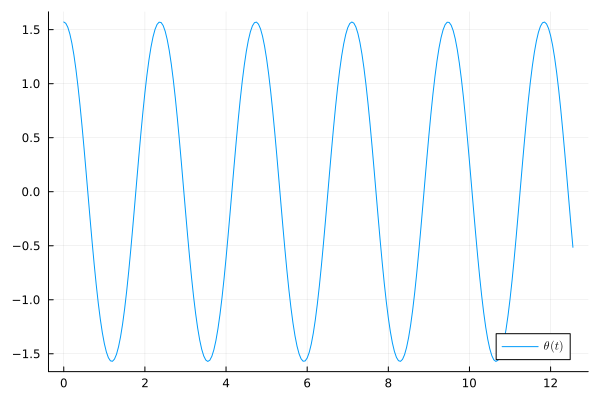

In [13]:
plot(time_range, getindex.(trajectory, 2), label = raw"$θ \, (t)$")
# plot!(t -> π/2 * cos(√(g/l) * t), time_range, label = raw"$\cos \, \left(\omega t\right)$", opacity = 0.4)

#### Phase space plot

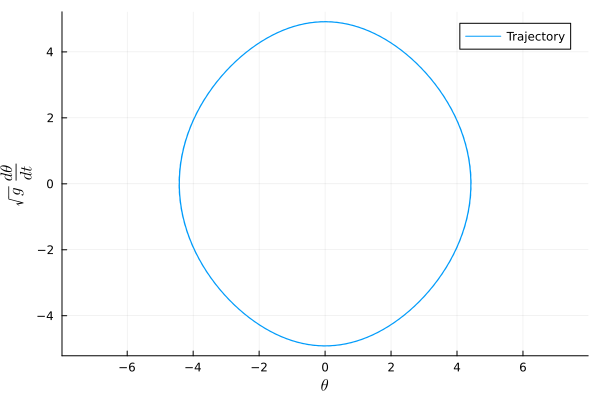

In [14]:
plot(getindex.(trajectory, 1), sqrt(g) * getindex.(trajectory, 2),
    idxs = (1, 2), label = "Trajectory",
    xlabel = raw"$θ$", ylabel = raw"$\sqrt{g} \, \frac{dθ}{dt}$",
    aspect_ratio = :equal)

### Energy analysis

Let's look at the system from the perspective of energy.

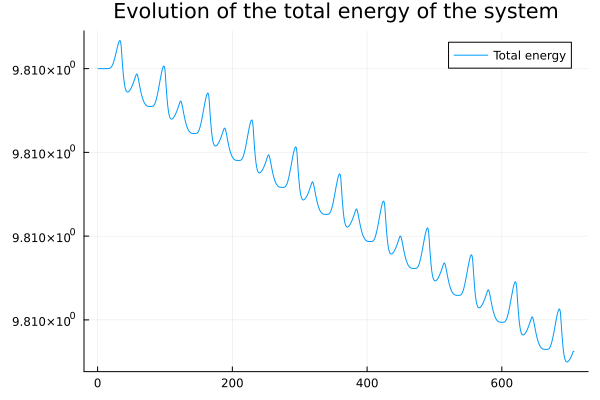

GKS: Possible loss of precision in routine SET_WINDOW


In [15]:
plot(getproperty.(saved_energies.saveval, :total),
    title = "Evolution of the total energy of the system",
    label = "Total energy")

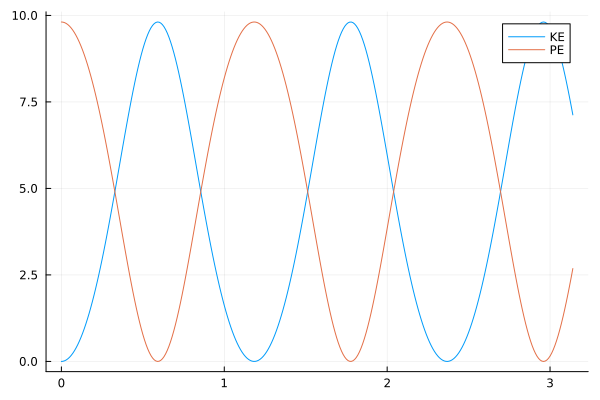

In [16]:
plot(t -> kinetic_energy(sol(t)[1]), 0:0.01:π, label = "KE")
# plot!(t -> (dθ₀ * cos(√(g/l) * t))^2/2, 0:0.01:π, label = "KE (analytic, for small-angle approximation)", opacity = 0.4)
plot!(t -> potential_energy(sol(t)[2]), 0:0.01:π, label = "PE")
# plot!(t -> dθ₀^2/2 * (1 - cos(dθ₀ * sin(√(g/l) * t))), 0:0.01:π, label = "PE (analytic, for small-angle approximation)", opacity = 0.4)

We can see that the total energy of the system (the sum of the kinetic and potential energies) is _almost_ constant. Unfortunately, the small deviation from a constant value is what will cause the solution to move away from the periodic behavior we'd expect.

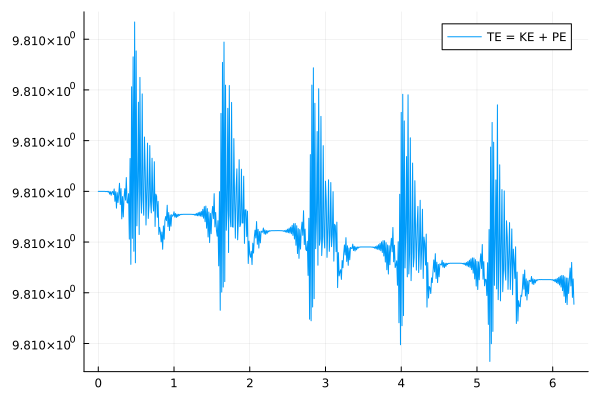

In [17]:
plot(t -> total_energy(sol(t)...), 0:0.01:2π, label = "TE = KE + PE")

## Driven oscillator

In this section, we will analyze a _driven oscillator_: a pendulum with a (periodic) external torque applied to it.

In [18]:
function driven_oscillator!(d²θ, dθ, u, p, t)
    @. d²θ = -g/l * sin(u) - p * sin(2π* t)
end

driven_oscillator! (generic function with 1 method)

In [19]:
prob = SecondOrderODEProblem(driven_oscillator!, [dθ₀], [θ₀], time_interval)

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 12.566370614359172)
u0: ([0.0], [1.5707963267948966])

In [20]:
frequency_interval = (0.5, 8)
interval_length = frequency_interval[2] - frequency_interval[1]

trajectories = 10

function prob_func(prob, i, repeat)
    new_frequency = frequency_interval[1] + (i - 1) * interval_length / trajectories
    remake(prob, p = new_frequency)
end

ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)

EnsembleProblem with problem ODEProblem

In [21]:
sim = solve(ensemble_prob, DPRKN6(), EnsembleThreads(), trajectories = trajectories);

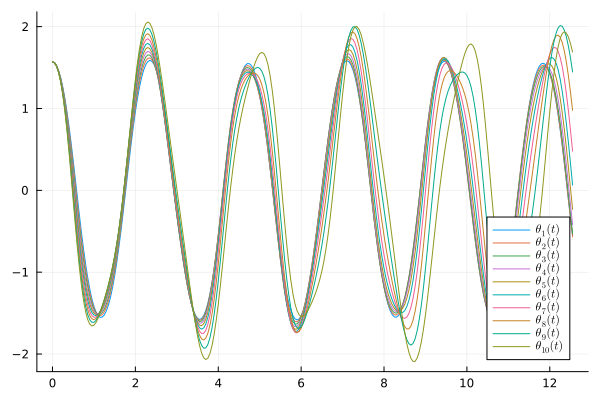

In [22]:
plot()
for (i, sol) in enumerate(sim)
    plot!(t -> sol(t)[2], 0:0.05:4π, label = "\$θ_{$i}(t)\$")
end
plot!()